Description:

The following code is get press 24 lubrication anomaly detection model. All lube points together.
Trained on Oct 12 data.

## Libraries

In [23]:
import json
import pickle
import pymongo
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
# import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
# Importing data_pre_processing module from Modules directory
import sys
sys.path.insert(1,r"D:\NGen Project files\3_Predictive Maintenance\github repos\Alert_generation_and_interlocking\Modules")
import data_pre_processing_module as dp
plot_width = 15
plot_height =10
# Other paths needed
threshold_sheet_path =  r"D:\NGen Project files\3_Predictive Maintenance\github repos\Alert_generation_and_interlocking\press_threshold_list.xlsx"

## Data Preparation

#### Get threshold dates

In [25]:
# Get the thresholds for job to job anomaly detection. This is needed for vibration sensors.
current_job     = "GM23398597_98"
press_number    = 24
try:
    thresholds = pd.read_excel(threshold_sheet_path,f"Press {press_number}").set_index("Jobs").to_dict()
    start_and_end = [thresholds["Start date"][current_job], thresholds["End date"][current_job]]
    
    # Entering dates for testing March 19 Hyd unit pressure
    # start_and_end=['2023,3,19,16,0,0', '2023,3,20,8,0,0']
    
    # For TESTING
    start_and_end=['2023,10,12,0,0,0', '2023,10,13,0,0,0'] # Lube doesn't depends on job.
    for date in start_and_end:
            #splitting the date
            runtime = date.split(',')
            #changing it all from str to int to be put into datetime format
            for i in range(0, len(runtime)):
                runtime[i] = int(runtime[i])
            if date == start_and_end[0]:
                job_start_date = datetime(runtime[0], runtime[1],runtime[2],runtime[3],runtime[4],runtime[5])
            elif date == start_and_end[1]:
                job_end_date = datetime(runtime[0], runtime[1],runtime[2],runtime[3],runtime[4],runtime[5])
    print("Current Job:",current_job,"\nThreshold start:",job_start_date,"\nThreshold ends:",job_end_date)
except Exception as E:
    print("Not able to read threshold sheet.",E)

Current Job: GM23398597_98 
Threshold start: 2023-10-12 00:00:00 
Threshold ends: 2023-10-13 00:00:00


#### Get Scaled X_Train

In [3]:
# We need to train multiple sensors. Need one universal function
def get_x_train(job_start_date,job_end_date,column_list):
    n_steps         = 19
    ob              = dp.data_pre_processing()
    ob.set_values(job_start_date,job_end_date,n_steps,column_list)
    X,df = ob.mongodb_to_X()
    X_train = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape) # Scaling of the data
    return X_train,df

In [4]:
# Find the lube corelation
column_list     = ["lub_flConRod_psi","lub_frConRodIn_psi","lub_rlConRodIn_psi","lub_rrConRodIn_psi",
                   "lub_frLwrLnkIn_psi","lub_flLwrLnkIn_psi","lub_rrLwrLnkIn_psi","lub_rlLwrLnkIn_psi",
                   "lub_rearBlk_psi","lub_frontBlk_psi","lub_preFltr_psi","lub_postFltr_psi"] 

X_train,df = get_x_train(job_start_date,job_end_date,column_list)

Batch information : {2: ['lub_flConRod_psi', 'lub_rlConRodIn_psi', 'lub_frLwrLnkIn_psi', 'lub_flLwrLnkIn_psi', 'lub_rrLwrLnkIn_psi', 'lub_rlLwrLnkIn_psi'], 3: ['lub_frConRodIn_psi', 'lub_rearBlk_psi'], 4: ['lub_rrConRodIn_psi', 'lub_frontBlk_psi', 'lub_preFltr_psi', 'lub_postFltr_psi']}
--> Shape of the data: batch_size=28802, time_steps=19, features=12


In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# df.head()

C:\Users\JSharma\AppData\Local\Temp/ipykernel_27668/1689417434.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,lub_flConRod_psi,lub_frConRodIn_psi,lub_rlConRodIn_psi,lub_rrConRodIn_psi,lub_frLwrLnkIn_psi,lub_flLwrLnkIn_psi,lub_rrLwrLnkIn_psi,lub_rlLwrLnkIn_psi,lub_rearBlk_psi,lub_frontBlk_psi,lub_preFltr_psi,lub_postFltr_psi
lub_flConRod_psi,1.00,0.38,-0.44,-0.52,0.11,0.08,0.10,0.09,0.00,0.01,-0.25,-0.25
lub_frConRodIn_psi,0.38,1.00,0.09,-0.34,-0.03,-0.05,-0.02,-0.01,-0.28,-0.24,0.12,0.13
lub_rlConRodIn_psi,-0.44,0.09,1.00,0.35,-0.16,-0.16,-0.15,-0.14,-0.33,-0.31,0.53,0.54
lub_rrConRodIn_psi,-0.52,-0.34,0.35,1.00,-0.15,-0.14,-0.14,-0.13,-0.18,-0.22,0.51,0.51
lub_frLwrLnkIn_psi,0.11,-0.03,-0.16,-0.15,1.00,-0.12,0.27,-0.11,0.12,0.10,-0.15,-0.15
lub_flLwrLnkIn_psi,0.08,-0.05,-0.16,-0.14,-0.12,1.00,-0.09,0.30,0.13,0.10,-0.17,-0.17
lub_rrLwrLnkIn_psi,0.10,-0.02,-0.15,-0.14,0.27,-0.09,1.00,-0.08,0.11,0.09,-0.13,-0.13
lub_rlLwrLnkIn_psi,0.09,-0.01,-0.14,-0.13,-0.11,0.30,-0.08,1.00,0.10,0.08,-0.14,-0.14
lub_rearBlk_psi,0.00,-0.28,-0.33,-0.18,0.12,0.13,0.11,0.10,1.00,-0.20,-0.44,-0.45
lub_frontBlk_psi,0.01,-0.24,-0.31,-0.22,0.10,0.10,0.09,0.08,-0.20,1.00,-0.32,-0.32


Corelation doesn't make sense. Maybe because in Lube schema , all lines have different blocks.

## Model Training


In [18]:
def build_model(input_shape,nodes):
    # build network topology
    model = keras.Sequential()
    # 1 LSTM layers                                                     
    model.add(keras.layers.LSTM(nodes, activation="relu", input_shape=input_shape))                                  
    #model.add(keras.layers.Dropout(rate=0.2))                                                   
    model.add(keras.layers.RepeatVector(X_train.shape[1]))                    
    #decoder                                                                                          
    model.add(keras.layers.LSTM(nodes, activation="relu",return_sequences=True))                                          
    #model.add(keras.layers.Dropout(rate=0.2))                                                         
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(X_train.shape[2])))         
    model.compile(optimizer='adam', loss='mae')                                           
    return model

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547248 entries, 2 to 1593064
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   lub_flConRod_psi    547248 non-null  float64
 1   lub_frConRodIn_psi  547248 non-null  float64
 2   lub_rlConRodIn_psi  547248 non-null  float64
 3   lub_rrConRodIn_psi  547248 non-null  float64
 4   lub_frLwrLnkIn_psi  547248 non-null  float64
 5   lub_flLwrLnkIn_psi  547248 non-null  float64
 6   lub_rrLwrLnkIn_psi  547248 non-null  float64
 7   lub_rlLwrLnkIn_psi  547248 non-null  float64
 8   lub_rearBlk_psi     547248 non-null  float64
 9   lub_frontBlk_psi    547248 non-null  float64
 10  lub_preFltr_psi     547248 non-null  float64
 11  lub_postFltr_psi    547248 non-null  float64
dtypes: float64(12)
memory usage: 54.3 MB


In [10]:
# Dataframe has different length columns. Need to fill the NULL values.
df.isna().sum()

lub_flConRod_psi      0
lub_frConRodIn_psi    0
lub_rlConRodIn_psi    0
lub_rrConRodIn_psi    0
lub_frLwrLnkIn_psi    0
lub_flLwrLnkIn_psi    0
lub_rrLwrLnkIn_psi    0
lub_rlLwrLnkIn_psi    0
lub_rearBlk_psi       0
lub_frontBlk_psi      0
lub_preFltr_psi       0
lub_postFltr_psi      0
dtype: int64

<AxesSubplot:>

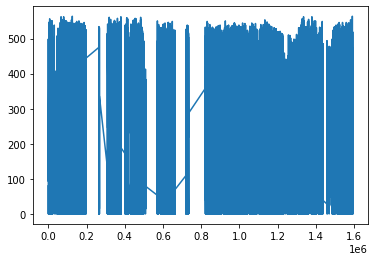

In [11]:
df["lub_rrConRodIn_psi"].plot()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5760      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 19, 32)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 19, 32)            8320      
                                                                 
 time_distributed_1 (TimeDis  (None, 19, 12)           396       
 tributed)                                                       
                                                                 
Total params: 14,476
Trainable params: 14,476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
811/811 [==============================

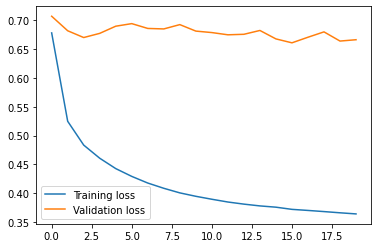

In [19]:
input_shape = (X_train.shape[1], X_train.shape[2])
# print("input_shape",input_shape)
model = build_model(input_shape,nodes=32)
model.summary()
# # fit model
history = model.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'],       label='Training loss')
plt.plot(history.history['val_loss'],   label='Validation loss')
plt.legend()
plt.show()

In [21]:
# model.save("p24_all_lube_psi_20240220.keras") # This is with MSE
model.save("p24_all_lube_psi_20240220_mae.keras") # This is with MAE